## Cocacola Sales Forecasting

#### In This Notebook

* Cocacola sales dataset
* Exploratory data analysis 
* Simple Moving Average(SMA)
* Exponential Moving Average(EMA)
* Autoregressive Model(AR)
* Autoregressive Integrated Moving Average (ARIMA)
* Seasonal Autoregressive Integrated Moving-Average (SARIMA)

### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

### The Data

In [3]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx',header=0,parse_dates=True)
df.head() #index_col=0

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


### EDA

<AxesSubplot:>

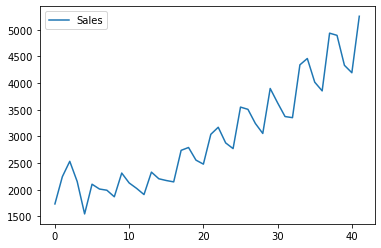

In [5]:
df.plot()

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

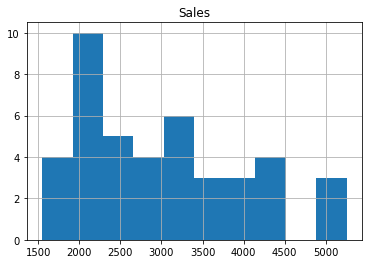

In [6]:
df.hist()

(array([2., 2., 9., 4., 5., 4., 6., 3., 4., 3.]),
 array([7.34460212, 7.46679737, 7.58899262, 7.71118787, 7.83338312,
        7.95557837, 8.07777362, 8.19996887, 8.32216412, 8.44435937,
        8.56655462]),
 <BarContainer object of 10 artists>)

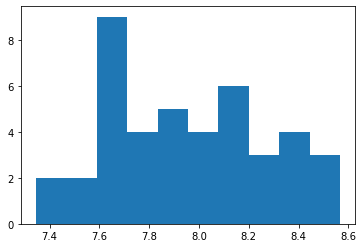

In [7]:
plt.hist(np.log(df['Sales'])) # log transformation

### Feature Engineering

In [8]:
# get dates format from quaters
final_list = []
quarter = list(df["Quarter"])
for qtr in quarter :
    if qtr[0:2] == "Q1":
        qtr = "01"+qtr[2:]
        final_list.append(qtr)
    elif qtr[0:2] == "Q2":
        qtr = "04"+qtr[2:]
        final_list.append(qtr)
    elif qtr[0:2] == "Q3":
        qtr = "07"+qtr[2:]
        final_list.append(qtr)
    elif qtr[0:2] == "Q4":
        qtr = "10"+qtr[2:]
        final_list.append(qtr)
df["Quarters"] = final_list

df["Date"] = pd.to_datetime(df["Quarters"], format="%m_%y")
df.drop(['Quarter', 'Quarters'],axis=1, inplace=True)

In [9]:
df.set_index(keys='Date', drop=True, inplace=True) #set date as index
df.head(3)

,Sales
Date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

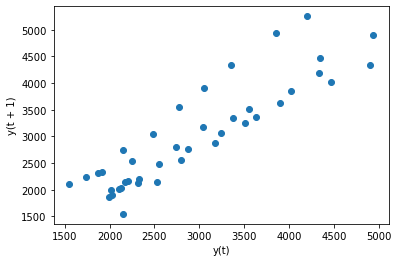

In [10]:
pd.plotting.lag_plot(df) # Lag plot

### Autocorrelation plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

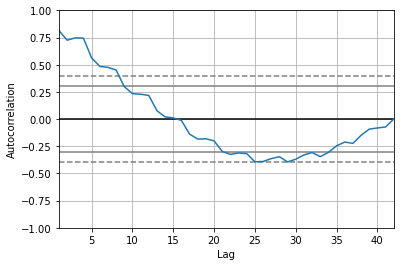

In [11]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])

### Upsampling

In [12]:
resampled = df.resample('M').fillna("pad") # resample the time series by 1 Month

<AxesSubplot:xlabel='Date'>

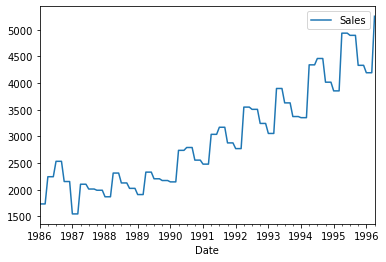

In [13]:
resampled.plot()

### AR Model

In [14]:
from statsmodels.tsa.ar_model import AutoReg

# Train/test split
train_data = df['Sales'][:len(df)-10]
test_data = df['Sales'][len(df)-10:]

# Instantiate and fit the AR model with training data
ar_model = AutoReg(train_data, lags=8).fit()

# Print Summary
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Sales   No. Observations:                   32
Model:                     AutoReg(8)   Log Likelihood                -147.700
Method:               Conditional MLE   S.D. of innovations            113.889
Date:                Mon, 22 Nov 2021   AIC                             10.304
Time:                        17:35:49   BIC                             10.795
Sample:                    01-01-1988   HQIC                            10.434
                         - 10-01-1993                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    116.0924    168.799      0.688      0.492    -214.747     446.932
Sales.L1       0.6767      0.202      3.347      0.001       0.280       1.073
Sales.L2      -0.2585      0.198     -1.307      0.1

C:\Users\shiva\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


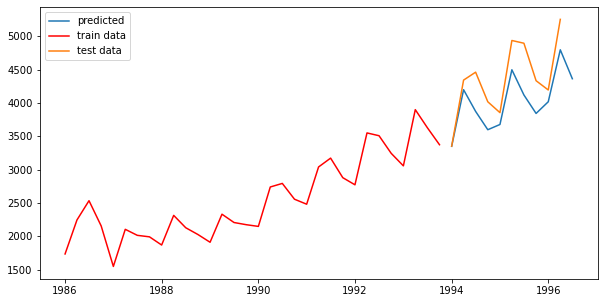

In [15]:
# Actual vs Predicted
pred = ar_model.predict(start=32, end=42, dynamic=False)
plt.figure(figsize=(10,5))
plt.plot(pred, label='predicted')
plt.plot(train_data, color='red', label='train data')
plt.plot(test_data, label='test data')
plt.legend();

### SMA

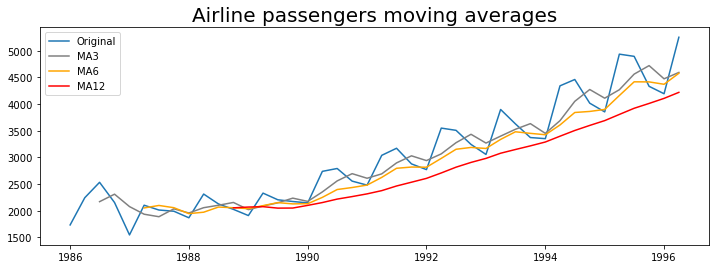

In [16]:
# moving average
df['MA3'] = df['Sales'].rolling(window=3).mean()
df['MA6'] = df['Sales'].rolling(window=6).mean()
df['MA12'] = df['Sales'].rolling(window=12).mean()

# Plot moving averages
plt.figure(figsize=(12,4))
plt.title('Airline passengers moving averages', size=20)
plt.plot(df['Sales'], label='Original')
plt.plot(df['MA3'], color='gray', label='MA3')
plt.plot(df['MA6'], color='orange', label='MA6')
plt.plot(df['MA12'], color='red', label='MA12')
plt.legend();

#### SMA on resampled data

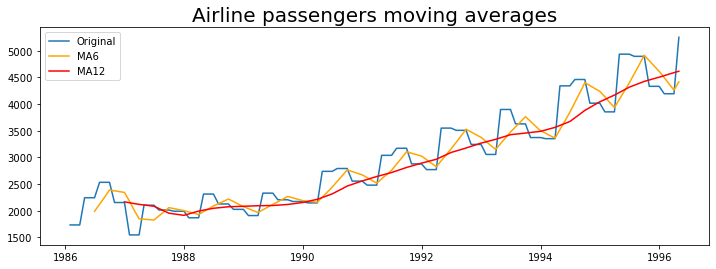

In [17]:
resampled['MA6'] = resampled['Sales'].rolling(window=6).mean()
resampled['MA12'] = resampled['Sales'].rolling(window=12).mean()

# Plot
plt.figure(figsize=(12,4))
plt.title('Airline passengers moving averages', size=20)
plt.plot(resampled['Sales'], label='Original')
plt.plot(resampled['MA6'], color='orange', label='MA6')
plt.plot(resampled['MA12'], color='red', label='MA12')
plt.legend();

### Exponantional weighted moving avarage(EWMA)


<AxesSubplot:xlabel='Date'>

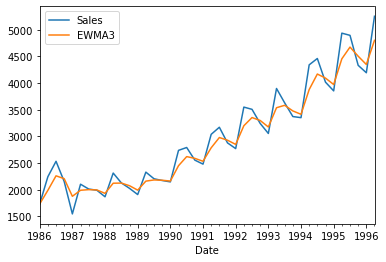

In [18]:
df['EWMA3']=df['Sales'].ewm(span=3,adjust=False).mean()
df[['Sales','EWMA3']].plot() 

#### EWMA on resampled data

<AxesSubplot:xlabel='Date'>

<Figure size 936x288 with 0 Axes>

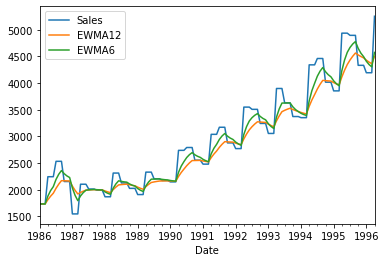

In [19]:
resampled['EWMA12']=resampled['Sales'].ewm(span=12,adjust=False).mean()
resampled['EWMA6']=resampled['Sales'].ewm(span=6,adjust=False).mean()

# plot
plt.figure(figsize=(13,4))
resampled[['Sales','EWMA12','EWMA6']].plot()

### Differencing
a method of transforming a time series 

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
adfuller(df['Sales'])
# there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

(1.3094210153268104,
 0.9966611673930905,
 7,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 395.6639212829265)

In [22]:
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)
resampled['Sales First Difference'] = resampled['Sales'] - resampled['Sales'].shift(1)

df['Seasonal First Difference'] = df['Sales']-df['Sales'].shift(12)
resampled['Seasonal First Difference'] = resampled['Sales']-resampled['Sales'].shift(12)

In [23]:
adfuller(df['Seasonal First Difference'].dropna()) #non-Stationary as p value is grater than 0.05

(-1.4618821846805747,
 0.5522764133805176,
 9,
 20,
 {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125},
 262.0031970871976)

<AxesSubplot:xlabel='Date'>

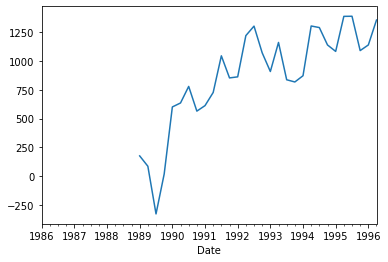

In [24]:
df['Seasonal First Difference'].plot()

#### Autocorrelation and Partial Autocorrelation plots

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

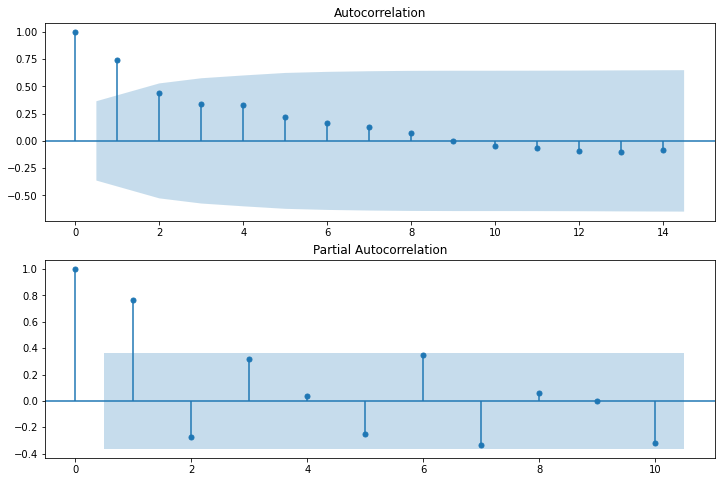

In [26]:
# Using autocorrelation plot and partial autocorrelation plot to decide p,q,d values
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=14,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=10,ax=ax2)

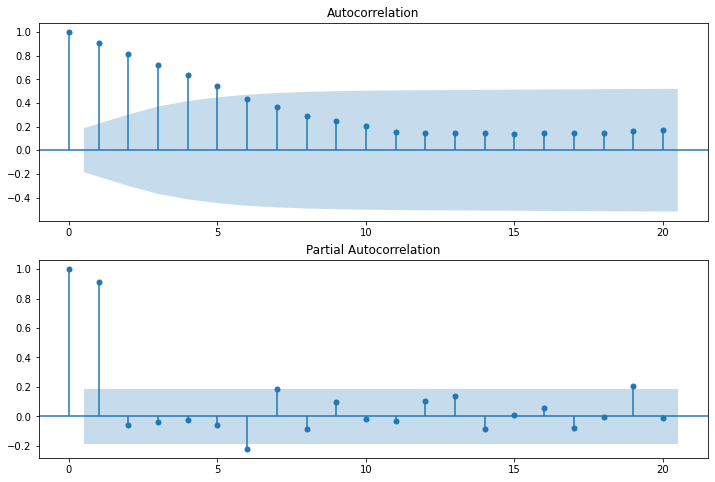

In [27]:
# On resampled data

# Using autocorrelation plot and partial autocorrelation plot to decide p,q,d values
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(resampled['Seasonal First Difference'].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resampled['Seasonal First Difference'].iloc[13:],lags=20,ax=ax2)

### ARMA

C:\Users\shiva\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


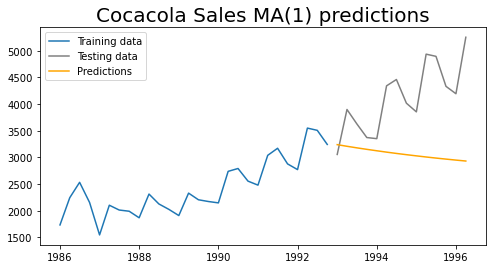

In [28]:
from statsmodels.tsa.arima_model import ARMA

# Train/test split
df_train = df[:-14]
df_test = df[-14:]

# Train the model
model = ARMA(df_train['Sales'], order=(1, 1))
results = model.fit()
predictions = results.forecast(steps=14)
predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])

# Plot
plt.figure(figsize=(8,4))
plt.title('Cocacola Sales MA(1) predictions', size=20)
plt.plot(df_train['Sales'], label='Training data')
plt.plot(df_test['Sales'], color='gray', label='Testing data')
plt.plot(predictions_df, color='orange', label='Predictions')
plt.legend();

C:\Users\shiva\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


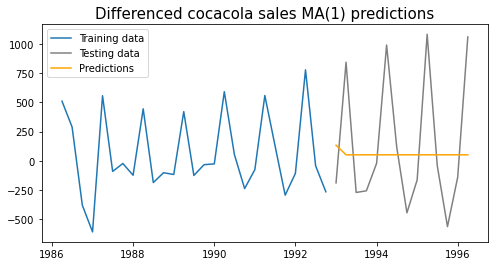

In [29]:
# On first lag difference
# Train Test Split
df_train = df[1:-14]
df_tesft = df[-14:]

# Train the model
model = ARMA(df_train['Sales First Difference'], order=(0, 1))
results = model.fit()
predictions = results.forecast(steps=14)
predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])

# Plot
plt.figure(figsize=(8,4))
plt.title('Differenced cocacola sales MA(1) predictions', size=15)
plt.plot(df_train['Sales First Difference'], label='Training data')
plt.plot(df_test['Sales First Difference'], color='gray', label='Testing data')
plt.plot(predictions_df, color='orange', label='Predictions')
plt.legend();

#### ARMA on Resampled Data

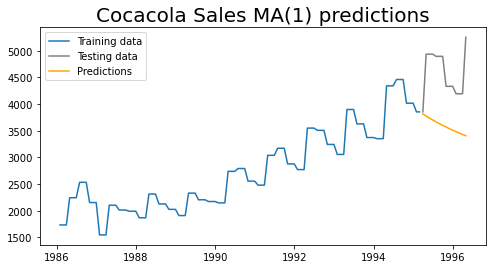

In [30]:
# Train/test split
df_train = resampled[:-14]
df_test = resampled[-14:]

# Train the model
model = ARMA(df_train['Sales'], order=(1, 1))
results = model.fit()
predictions = results.forecast(steps=14)
predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])

# Plot
plt.figure(figsize=(8,4))
plt.title('Cocacola Sales MA(1) predictions', size=20)
plt.plot(df_train['Sales'], label='Training data')
plt.plot(df_test['Sales'], color='gray', label='Testing data')
plt.plot(predictions_df, color='orange', label='Predictions')
plt.legend();

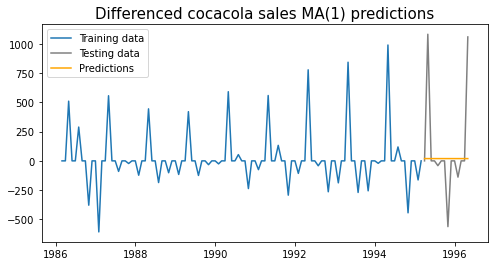

In [31]:
# first lag difference
# Train Test Split
df_train = resampled[1:-14]
df_tesft = resampled[-14:]

# Train the model
model = ARMA(df_train['Sales First Difference'], order=(0, 1))
results = model.fit()
predictions = results.forecast(steps=14)
predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])

# Plot
plt.figure(figsize=(8,4))
plt.title('Differenced cocacola sales MA(1) predictions', size=15)
plt.plot(df_train['Sales First Difference'], label='Training data')
plt.plot(df_test['Sales First Difference'], color='gray', label='Testing data')
plt.plot(predictions_df, color='orange', label='Predictions')
plt.legend();

### ARIMA

In [32]:
from statsmodels.tsa.arima_model import ARIMA

# Model Building
model = ARIMA(df['Sales'],order=(1,0,3))
fitted = model.fit()

#forecasting
df['forecast'] = fitted.predict(32,end=None)

C:\Users\shiva\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

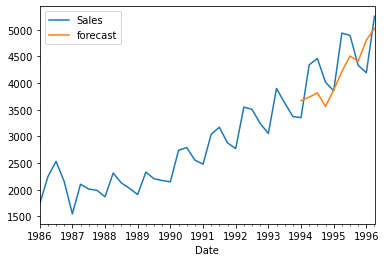

In [33]:
df[['Sales','forecast']].plot()

#### ARIMA on Resample 

<AxesSubplot:xlabel='Date'>

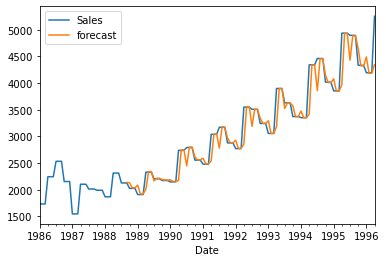

In [34]:
# Model Building
model = ARIMA(resampled['Sales'],order=(1,0,3))
fitted = model.fit()

#forecasting
resampled['forecast'] = fitted.predict(32,end=None)
resampled[['Sales','forecast']].plot()

### SARIMA

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\shiva\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\shiva\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\shiva\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Date'>

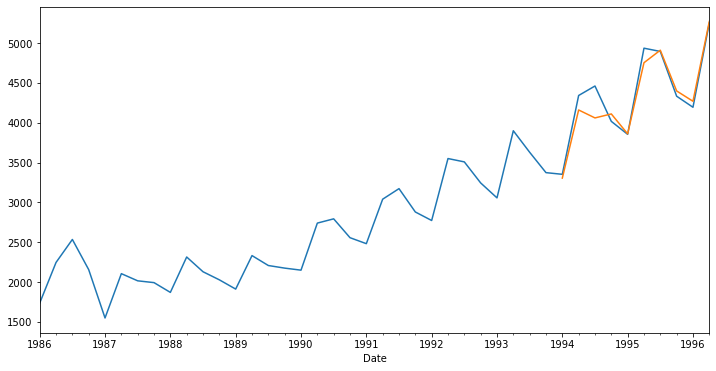

In [36]:
model2 = SARIMAX(df['Sales'],order=(8,1,1),seasonal_order=(0, 0, 0, 12))

fitted2 = model2.fit()

df['forecast2'] = fitted2.predict(32,end=None)
plt.figure(figsize=(12,6))
df['Sales'].plot()
df['forecast2'].plot()

#### SARIMA on Resampled data


<AxesSubplot:xlabel='Date'>

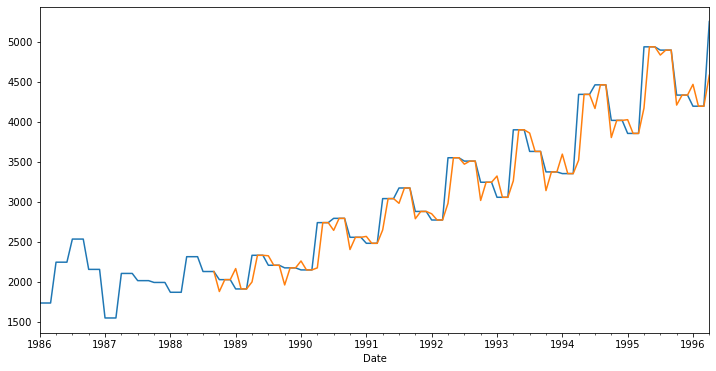

In [37]:
model2 = SARIMAX(resampled['Sales'],order=(8,1,1),seasonal_order=(0, 0, 0, 12))

fitted2 = model2.fit()

resampled['forecast2'] = fitted2.predict(32,end=None)
plt.figure(figsize=(12,6))
resampled['Sales'].plot()
resampled['forecast2'].plot()

We can use ARIMA and SARIMA model for forecasting cocacola sales.

### Linear Models

In [45]:
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx',header=0,parse_dates=True)
data['quaters'] = data['Quarter'].apply(lambda x: x[0:2])

In [46]:
data.head()

,Quarter,Sales,quaters
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


Thank you!